# *Importing required modules*

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# General & for data storing and processing 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import math
from itertools import islice
    
# for plotting graphs
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
    
# for images
import cv2 as cv #open-cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
# dealing with files and directories 
import os
import shutil
    
# numeralize classes 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
   
# kfold train-test split
from sklearn.model_selection import StratifiedKFold
   
# for model and layers
import tensorflow
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers 
    
 # model optimizer
from tensorflow.keras.optimizers import Adam

# Model-callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# *Data preprocessing*

In [18]:
def processData(dataframe):
    print("\n dataFrame with multilabel seprated into rows: ")
    raw_data = dataframe
    print(raw_data)

    encoding = {}
    val = 0
    for classes in np.sort(raw_data["Finding Labels"].unique()):
        encoding[classes] = val
        val += 1
    
    # converting dataFrame with all multilabel in a single row
    raw_data.set_index("Image Index", inplace = True)

    data = pd.DataFrame(columns = ["Image Index", "Finding Labels", "path", "Class Vector"])
    count = 0

    for img in raw_data.index.unique():
        res = raw_data.loc[img].values.tolist()
        classes = []
        if(len(res) > 1):
            for item in res:
                classes.extend(item)
        else:
            classes = res
        
        class_vec = list()
        for clas in classes:
            class_vec.append(encoding[clas])

            
        path = '/kaggle/input/dataset/Expert_labeled_Images/' + img
        df = pd.DataFrame(data = [[img, classes, path, class_vec]], columns = ["Image Index", "Finding Labels", "path", "Class Vector"], index = {count})
        data = data.append(df)
        count += 1

    
    print('\n dataFrame with multilabel are in a list')
    return data

#processData(raw_data)

# *Selecting the model and setting up the hyperparameter*

In [19]:
def set_hyperparameters(BASE_MODEL = 'VGG16', EPOCHS = 20, INPUT_SHAPE = (224,224,3), DENSE_COUNT_HIDDEN_LAYER = 512, DENSE_COUNT_OUTPUT_LAYER = 9, LEARNING_RATE = 0.0003,
                        DROPOUT_1 = 0.3, DROPOUT_2 = 0.2, BATCH_SIZE = 32, STEPS_PER_EPOCH = 33, VALIDATION_STEPS = 8, REGULARIZATION_LAMBDA = 0) :

    # returns func arguments as a dictionary
    h_parameters = locals()
    
    if BASE_MODEL=='VGG16':
        from tensorflow.keras.applications.vgg16 import VGG16 as Model, preprocess_input
    elif BASE_MODEL == 'VGG19':
        from tensorflow.keras.applications.vgg19 import VGG19 as Model, preprocess_input
    elif BASE_MODEL=='RESNET52':
        from tensorflow.keras.applications.resnet50 import ResNet50 as Model, preprocess_input
    elif BASE_MODEL=='InceptionV3':
        from tensorflow.keras.applications.inception_v3 import InceptionV3 as Model, preprocess_input
    elif BASE_MODEL=='Xception':
        from tensorflow.keras.applications.xception import Xception as Model, preprocess_input
    elif BASE_MODEL=='DenseNet169': 
        from tensorflow.keras.applications.densenet import DenseNet169 as Model, preprocess_input
    elif BASE_MODEL=='DenseNet121':
        from tensorflow.keras.applications.densenet import DenseNet121 as Model, preprocess_input
    elif BASE_MODEL=='DenseNet201':
        from tensorflow.keras.applications.densenet import DenseNet201 as Model, preprocess_input
    elif BASE_MODEL=='EfficientNetB7':
        from tensorflow.keras.applications.efficientnet import EfficientNetB7 as Model, preprocess_input
    elif BASE_MODEL == 'MobileNet' :
        from tensorflow.keras.applications.mobilenet import MobileNet as Model, preprocess_input
    elif BASE_MODEL == 'RESNET101' :
        from tensorflow.keras.applications.resnet import ResNet101 as Model, preprocess_input
    else:
        raise ValueError('Unknown model: {}'.format(BASE_MODEL))
    
    return {'Model' : Model, 'preprocess_input' : preprocess_input, 'h_parameters' : h_parameters}


#parameters = set_hyperparameters()
#h_parameters = parameters['h_parameters']


# *Setting up pre-trained Model*

In [20]:
def set_ptm(parameters):
    
    Model =  parameters['Model']
    h_parameters = parameters['h_parameters']
    
    Pre_trained_model = Model(input_shape = h_parameters['INPUT_SHAPE'], include_top = False, weights = 'imagenet')
    Pre_trained_model.trainable = False
    for layer in Pre_trained_model.layers:
        layer.trainable = False
    
    Pre_trained_model.summary()
    return Pre_trained_model

#ptm = set_ptm(parameters)

# *Creating the TL Model by flatning the last layer o/p of PTM and adding dense layer to it*

In [21]:
def create_TL_model(Pre_trained_model, h_parameters): 
    
    DROPOUT_1 = h_parameters['DROPOUT_1']
    DROPOUT_2 = h_parameters['DROPOUT_2']
    REGULARIZATION_LAMBDA = h_parameters['REGULARIZATION_LAMBDA']
    DENSE_COUNT_HIDDEN_LAYER = h_parameters['DENSE_COUNT_HIDDEN_LAYER']
    DENSE_COUNT_OUTPUT_LAYER = h_parameters['DENSE_COUNT_OUTPUT_LAYER']
    

    # setting a layer trainable:
    #layer_name = 'block5_conv3'
    #'conv5_block3_3_conv'  #for resnet52
    # for vgg-16 => 
    #Pre_trained_model.get_layer(layer_name).trainable = True
    
    # getting the last layer
    ptm_last_layer = Pre_trained_model.get_layer(index = -1)
    print("pre-trained-model last layer o/p shape  :", ptm_last_layer.output_shape)
    last_layer_output = ptm_last_layer.output

    add_on =  GlobalAveragePooling2D()(last_layer_output)
    #add_on = Dropout(DROPOUT_1)(add_on)
    add_on = Dense(units = DENSE_COUNT_HIDDEN_LAYER,kernel_regularizer = regularizers.l2(REGULARIZATION_LAMBDA) ,activation = 'relu')(add_on)
    #add_on = Dropout(DROPOUT_2)(add_on)
    
    # Adding the 9-class output layer
    add_on = Dense(units = DENSE_COUNT_OUTPUT_LAYER, kernel_regularizer = regularizers.l2(REGULARIZATION_LAMBDA), activation = 'sigmoid')(add_on)

    TL_model = Model(Pre_trained_model.input, add_on)
             
    TL_model.summary()
    
    return TL_model

#TL_model = create_TL_model(ptm, h_parameters)

# *Model compilation*

In [22]:
def compile_model(TL_model, h_parameter):
    TL_model.compile(optimizer = Adam(learning_rate = h_parameter['LEARNING_RATE']), metrics = ['binary_accuracy'], loss = 'binary_crossentropy')

#compile_model(TL_model)

# *Image Generators*

In [23]:
def generate_images():
     
    train_data_gen = ImageDataGenerator(shear_range = 0.1, zoom_range = 0.2, height_shift_range = 0.1)
    valid_data_gen = ImageDataGenerator()
    test_data_gen = ImageDataGenerator()
    
    return {'train_img_gen' : train_data_gen, 'valid_img_gen' : valid_data_gen, 'test_img_gen' : test_data_gen}

# *Code for Early stopping*

In [24]:
def callbacks():
    
    weight_path="{}_weights.best.hdf5".format('lung_opacity')

    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=20, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
    early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited
    callbacks_list = [checkpoint, early, reduceLROnPlat]
    
    return callbacks_list

#callback_list = callbacks()

# *Training the models*

In [25]:
def train_model(model, train_gen, valid_gen, h_parameters):
    
    # steps_per_epoch = (training size//batch size)
    history = model.fit(train_gen, validation_data = valid_gen, epochs = h_parameters['EPOCHS'], steps_per_epoch = h_parameters['STEPS_PER_EPOCH'] , validation_steps = h_parameters['VALIDATION_STEPS'], workers = os.cpu_count())
    return history

#history = train_model(TL_model, train_gen, valid_gen)

# *Evaluating the results*

In [26]:
def plot_results(history):
    results = history.history
    loss = results['loss']
    binary_accuracy = results['binary_accuracy']
    val_loss = results['val_loss']
    val_binary_accuracy = results['val_binary_accuracy']
    
    plt.subplots(figsize = (14,5))
    plt.subplot(1,2,1)
    plt.title(label = "Accuracy  v/s epochs")
    plt.plot(binary_accuracy, 'r-', label = 'Training Accuracy')
    plt.plot(val_binary_accuracy, 'b-', label = 'Validation Accuracy')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(label = "Loss  v/s epochs")
    plt.plot(loss, 'r-', label = 'Training Loss')
    plt.plot(val_loss, 'b-', label = 'Validation Loss')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()
    
    plt.tight_layout(pad = 4)
    plt.show()
    
#plot_results(history)

# *Saving the result history*

In [27]:
def save_history_to_results(history, h_parameters):
    
    hyper_parameters = h_parameters
    result_history.append([history , hyper_parameters])
    print('Total results : ',len(result_history))
    return result_history

#result_history = save_history_to_results(history, h_parameters)

# *View Results*

In [28]:
def view_results(result_history):
    
    #print('lets run the model for VGG16, 100 epochs, (224,224) input, 512 hidden layer inputs, 9 o/p layer neurons, DROPOUT = (0.5,0.4), 16 batch_size, 60 steps / EPOCH, NO Regularization (just dropouts)')
    #print('We will run for different learning rates : 1e-2, 3 *1 e-2, 1e-3, 3 * 1e-3, 1e-4 ')
    for item in result_history:
        hist = item[0]
        h_parameters = item[1]
        print('parameters : \n')
    
        i = 0
        for parameter in h_parameters:
           # print(parameter)
            print(parameter, ' = ', h_parameters[parameter])
            i = i+1
        plot_results(hist)
    
        print('\n\n')


# *Saving the Model*

In [29]:
def save_model(model, location):

    if(os.path.isdir(location)):
        shutil.rmtree(location)
    
    TL_model.save(location)
    
#location = '/kaggle/working/saved_models/' + h_parameters['BASE_MODEL'] + '/'
#save_model(TL_model, location )

# *Running the script*

In [30]:
# importing required libraries
#import_required()

import tensorflow

raw_data = pd.read_csv('/kaggle/input/dataset/labels.csv')
raw_data = raw_data[["Image Index", "Finding Labels"]]

data = processData(raw_data)
# shuffle data
data = data.sample(frac = 1).reset_index(drop = True)
print(data.head().to_markdown())

# seprate test data from train data
train_index = math.floor(0.85 * len(data))
train_and_valid_data = data.loc[0:train_index]
train_size = math.floor(len(train_and_valid_data) * 0.8)
    
train_data = train_and_valid_data[0:train_size]
valid_data = train_and_valid_data[train_size:len(train_and_valid_data)]
test_data  = data.loc[train_index : len(data)]
    
print('train_samples : ',len(train_data))
print('valid_samples : ',len(valid_data))
print('test_samples : ',len(test_data))

result_history = []

# choose model, preprocess_input, hyper-parameters
parameters = set_hyperparameters()
h_parameters = parameters['h_parameters']

# setting up pre-trained-model
ptm = set_ptm(parameters)

# create TL model by adding up of layers
TL_model = create_TL_model(ptm, h_parameters)
    
# compile the model
compile_model(TL_model, h_parameters)

# Image augmentation using generators
generators = generate_images()
train_data_gen = generators['train_img_gen']
valid_data_gen = generators['valid_img_gen']
test_data_gen = generators['test_img_gen']
    
train_gen = train_data_gen.flow_from_dataframe(train_data, x_col = 'path', y_col = 'Class Vector', target_size = (224,224), class_mode = 'categorical', batch_size = h_parameters['BATCH_SIZE'])
valid_gen = valid_data_gen.flow_from_dataframe(valid_data, x_col = 'path', y_col = 'Class Vector', target_size = (224,224), class_mode = 'categorical', batch_size = h_parameters['BATCH_SIZE'])
    
# train_model
history = train_model(TL_model, train_gen, valid_gen, h_parameters)



 dataFrame with multilabel seprated into rows: 
           Image Index Finding Labels
0     00000013_008.png     No Finding
1     00000032_002.png     No Finding
2     00000032_009.png     No Finding
3     00000116_038.png     No Finding
4     00000116_039.png     No Finding
...                ...            ...
1935  00000711_004.png    Atelectasis
1936  00000785_000.png    Atelectasis
1937  00000827_016.png    Atelectasis
1938  00000877_003.png    Atelectasis
1939  00000877_037.png    Atelectasis

[1940 rows x 2 columns]

 dataFrame with multilabel are in a list
|    | Image Index      | Finding Labels                  | path                                                         | Class Vector   |
|---:|:-----------------|:--------------------------------|:-------------------------------------------------------------|:---------------|
|  0 | 00016014_012.png | ['Mass']                        | /kaggle/input/dataset/Expert_labeled_Images/00016014_012.png | [4]            |
|  1 | 0

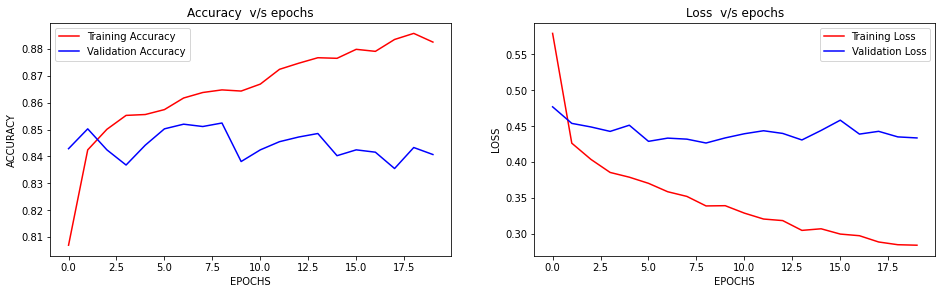

Total results :  1
Found 228 validated image filenames.


In [31]:
# plot model results
plot_results(history)
    
# saving the model_history
result_history = save_history_to_results(history, h_parameters)

test_gen = test_data_gen.flow_from_dataframe(test_data, x_col = 'path', y_col = 'Class Vector', target_size = (224,224), class_mode = None, batch_size = 1, shuffle = False)

prediction = TL_model.predict(test_gen)


In [80]:
import sys

np.set_printoptions(threshold = 5)

y_pred = []
i = 0
for vec in test_data['Class Vector']:
    length = len(vec)
    res = np.argpartition(prediction[i], -length)[-length:].tolist()
    y_pred.append(res)
    i += 1

y_pred.append([0,1,2,3,4,5,6,7,8])

y_test = test_data['Class Vector'].tolist()
y_test.append([0,1,2,3,4,5,6,7,8])

from sklearn.preprocessing import MultiLabelBinarizer
y_pred = MultiLabelBinarizer().fit_transform(y_pred)
y_test = MultiLabelBinarizer().fit_transform(y_test)

print('\n',y_pred)
print('\n',y_test)

from sklearn.metrics import multilabel_confusion_matrix
confusion = multilabel_confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']))




 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]]

 [[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
Confusion Matrix

[[[151  41]
  [ 21  16]]

 [[195  17]
  [ 11   6]]

 [[155  42]
  [ 16  16]]

 ...

 [[158  23]
  [ 34  14]]

 [[216   0]
  [ 12   1]]

 [[174  18]
  [ 29   8]]]

Accuracy: 0.21

Micro Precision: 0.31
Micro Recall: 0.31
Micro F1-score: 0.31

Macro Precision: 0.40
Macro Recall: 0.30
Macro F1-score: 0.29

Weighted Precision: 0.36
Weighted Recall: 0.31
Weighted F1-score: 0.30

Classification Report

              precision    recall  f1-score   support

     Class 1       0.28      0.43      0.34        37
     Class 2       0.26      0.35      0.30        17
     Class 3       0.28      0.50      0.36        32
     class 4       0.50      0.31      0.38        42
     class 5       0.40      0.26      0.32        38
     class 6 